In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import xarray as xr
import glob
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

import sensor_info
import model_class
import dataset_class
import local_functions
import stats
import model_operations
from tqdm import tqdm

satellite = sensor_info.satellite
sensor = sensor_info.sensor

In [3]:
model_tree = model_operations.load_model_tree()

In [15]:
'''
Load in test data and predict Tbs: Do all scan positions:
'''

pixel_nums = np.arange(0,48)

#Ocean
sfc = [1]

with xr.open_dataset(f'training_data/{satellite}_training_data.nc') as f:
    sfctype = f.sfctype.values
    correct_sfc = sfctype == 1
    Tbs_all = f.Tbs.values[correct_sfc]
    scanpos = f.scanpos.values[correct_sfc]
    sfctype_all = sfctype[correct_sfc]

y_true = {}
y_pred = {}

In [13]:
Tbs_all.shape, sfctype_all.shape

((115044867, 9), (115044867,))

In [28]:
import importlib; importlib.reload(model_operations)

for ipix in tqdm(pixel_nums):
    
   # scan_position = ipix

    correct_scanpos = scanpos == ipix

    scan_position = scanpos[correct_scanpos]

    Tbs = Tbs_all[correct_scanpos]
    sfctype = sfctype_all[correct_scanpos]

    #---Split data into train/test/val:
    train_indcs, test_indcs, val_indcs = local_functions.split_data_indcs(Tbs)

    Tbs_test = Tbs[test_indcs]
    sfctype  = sfctype[test_indcs]
    scan_position = scan_position[test_indcs]

    y_true[f'scanpos{ipix}'] = Tbs_test
    
    #Run predictions on test data:
    y_pred[f'scanpos{ipix}'] = model_operations.run_predictions(Tbs_test, sfctype, scan_position, model_tree, keep_dims=False)

  0%|                                                                                                                                  | 0/48 [00:02<?, ?it/s]

[[164.04 166.93 213.45 ... 250.61 244.16 238.62]
 [156.61 160.05 206.98 ... 250.43 243.41 237.98]
 [152.38 156.04 204.32 ... 250.47 244.31 239.27]
 ...
 [156.17 162.12 207.05 ... 253.11 247.7  242.41]
 [155.3  161.57 206.75 ... 253.44 247.64 243.07]
 [162.36 168.23 210.59 ... 253.97 247.34 242.4 ]]
[1 1 1 ... 1 1 1]


RuntimeError: No active exception to reraise

((239665, 9), (239665, 9))

In [29]:
'''
Calculate error statistics
'''

rmse = {}
mse = {}
mae = {}
error = {}
mean_error = {}
std_error = {}

for ipix in pixel_nums:
    rmse[f'scanpos{ipix}'] = stats.root_mean_squared_error(y_pred[f'scanpos{ipix}'], y_true[f'scanpos{ipix}'], axis=0)
    mse[f'scanpos{ipix}'] = stats.mean_squared_error(y_pred[f'scanpos{ipix}'], y_true[f'scanpos{ipix}'], axis=0)
    mae[f'scanpos{ipix}'] = stats.mean_absolute_error(y_pred[f'scanpos{ipix}'], y_true[f'scanpos{ipix}'], axis=0)

    error[f'scanpos{ipix}'] = y_pred[f'scanpos{ipix}'] - y_true[f'scanpos{ipix}']
    mean_error[f'scanpos{ipix}'] = np.mean(error[f'scanpos{ipix}'], axis=0)
    std_error[f'scanpos{ipix}']  = np.std(error[f'scanpos{ipix}'], axis=0)

    # print('Error stats:')
    # print('mean: ', mean_error)
    # print('std: ', std_error)

    # mean_error[f'scanpos{ipix}'].astype(np.float32).tofile(f'eval_stats/mean_ocn_scanpos{ipix}.arr',
    #                                                         sep='', format='unformatted')
    # std_error[f'scanpos{ipix}'].astype(np.float32).tofile(f'eval_stats/std_ocn_scanpos{ipix}.arr', 
    #                                                        sep='', format='unformatted')
    raise

RuntimeError: No active exception to reraise

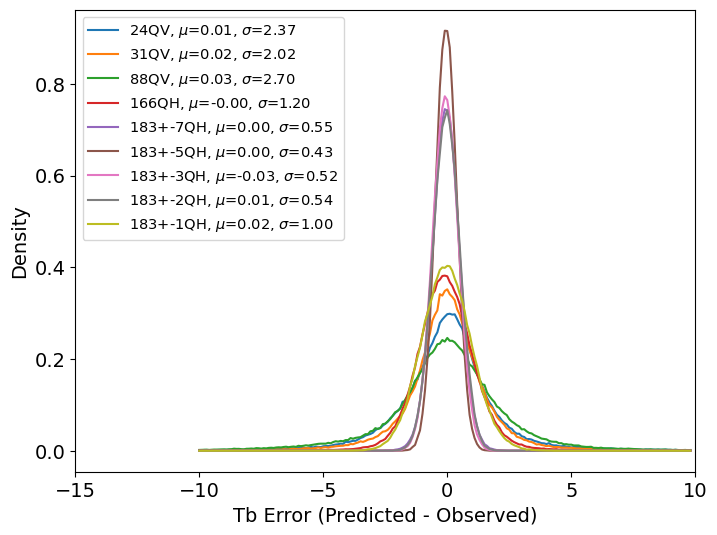

In [8]:
scan_position = 0

nchans = sensor_info.nchannels

bin_edges = np.arange(-10,10,0.1)
dens = np.zeros([bin_edges.size - 1,nchans])

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    dens[:,ichan], bin_edges = np.histogram(error[f'scanpos{scan_position}'][:,ichan], bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], dens[:,ichan], 
        label=f'{channel}, $\\mu$={mean_error[f'scanpos{scan_position}'][ichan]:.2f}, $\\sigma$={std_error[f'scanpos{scan_position}'][ichan]:.2f}')

plt.xlim(-15,10)
plt.tick_params('both', labelsize=14)
plt.xlabel('Tb Error (Predicted - Observed)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper left', fontsize=10.5)


plt.show()


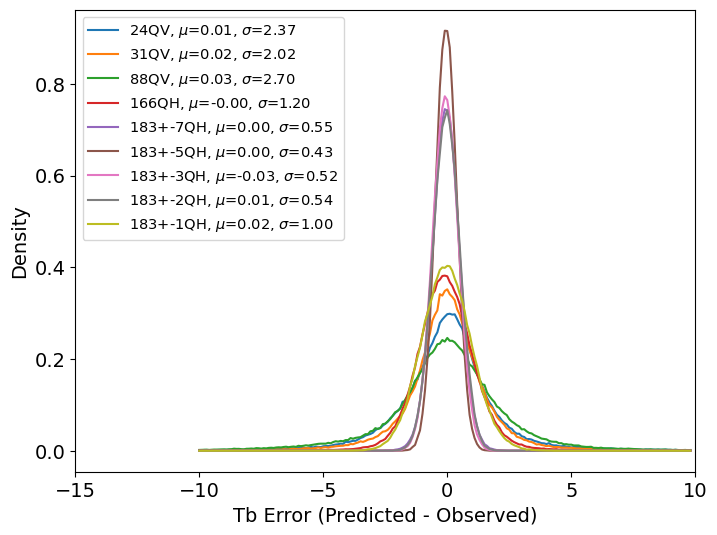

In [30]:
scan_position = 0

nchans = sensor_info.nchannels

bin_edges = np.arange(-10,10,0.1)
dens = np.zeros([bin_edges.size - 1,nchans])

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    dens[:,ichan], bin_edges = np.histogram(error[f'scanpos{scan_position}'][:,ichan], bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], dens[:,ichan], 
        label=f'{channel}, $\\mu$={mean_error[f'scanpos{scan_position}'][ichan]:.2f}, $\\sigma$={std_error[f'scanpos{scan_position}'][ichan]:.2f}')

plt.xlim(-15,10)
plt.tick_params('both', labelsize=14)
plt.xlabel('Tb Error (Predicted - Observed)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper left', fontsize=10.5)


plt.show()


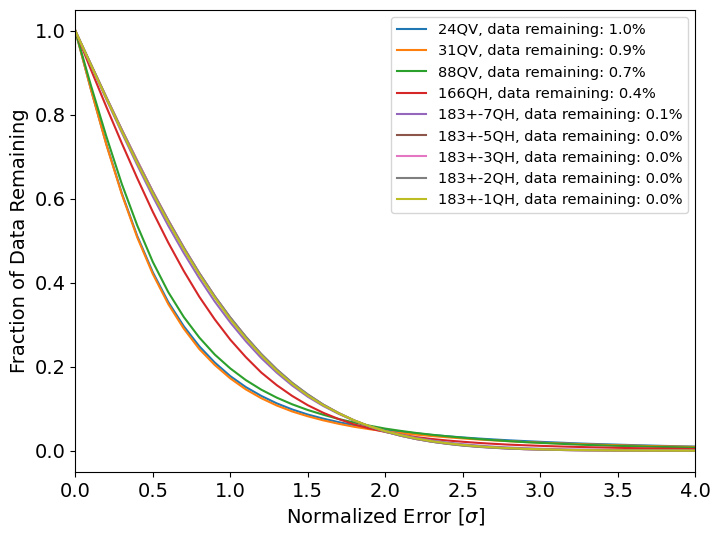

In [9]:
'''
Plot fraction of data that remains as a function of 
standard deviation (sigma) from the mean.
'''

bin_edges = np.arange(0,10,0.1)
#Get errors in units of sigma
norm_error = ((error[f'scanpos{scan_position}'] - error[f'scanpos{scan_position}'].mean(axis=0))/
              error[f'scanpos{scan_position}'].std(axis=0))

frac_rem = np.zeros([bin_edges.size - 1, nchans])
for ichan, channel in enumerate(sensor_info.feature_descriptions):
    #Get histogram of absolute error [sigma] as a function of sigma
    counts, bin_edges = np.histogram(np.abs(norm_error[:,ichan]), bins=bin_edges)

    #Get reverse cumulative sum of counts as a function of sigma:
    revcumsum = np.flip(np.cumsum(np.flip(counts)))

    #Calculate the fraction of remaining data as a function of sigma:
    frac = revcumsum / counts.sum()

    #Save this result. It is the fraction of data remaining as we move
    #   farther from the mean in sigma space.
    frac_rem[:,ichan] = frac

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    plt.plot(bin_edges[:-1], frac_rem[:,ichan], 
             label=f'{channel}, data remaining: {frac_rem[40,ichan]*100.:.1f}%')

plt.xlim(0,4)
plt.tick_params('both', labelsize=14)
plt.xlabel('Normalized Error [$\\sigma$]', fontsize=14)
plt.ylabel('Fraction of Data Remaining', fontsize=14)
plt.legend(fontsize=10.5)
plt.show()


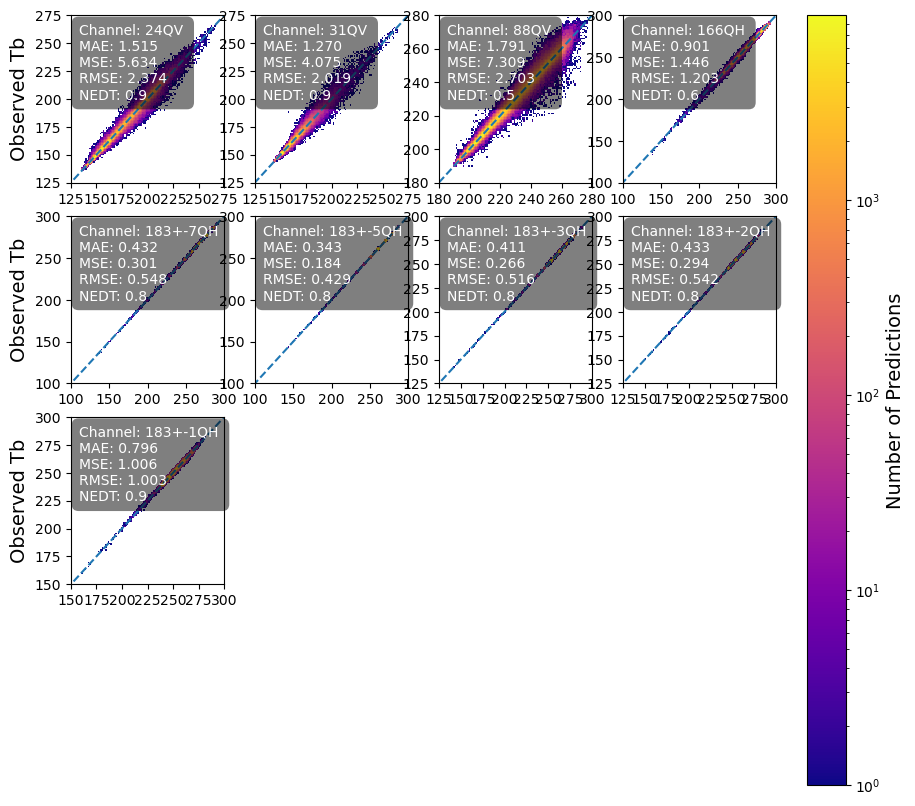

In [12]:
'''
Plot results
'''

nedt = sensor_info.nedt

nrows, ncols = (4,4)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0

channels2plot = sensor_info.feature_descriptions
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow,icol].axis('off')
            continue
        channel = channels2plot[i]
        min_lim, max_lim = y_true[f'scanpos{scan_position}'][:,i].min(), y_true[f'scanpos{scan_position}'][:,i].max()
        mesh = ax[irow,icol].hist2d(y_pred[f'scanpos{scan_position}'][:,i],y_true[f'scanpos{scan_position}'][:,i],
                                    bins=100, norm=LogNorm(), cmap='plasma',
                             range=[[min_lim,max_lim],[min_lim,max_lim]])
        ticks = ax[irow,icol].get_yticks()
        ax[irow,icol].set_xticks(ticks); ax[irow,icol].set_yticks(ticks)
        ax[irow,icol].plot(np.arange(0,400), np.arange(0,400), linestyle='--')
        ax[irow, icol].text(0.05, 0.95, 
        f'Channel: {channel} \nMAE: {mae[f'scanpos{scan_position}'][i]:.3f} \nMSE: {mse[f'scanpos{scan_position}'][i]:.3f} \nRMSE: {rmse[f'scanpos{scan_position}'][i]:.3f} \nNEDT: {nedt[i]}', 
                            ha='left', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        if icol == 0:
            ax[irow,icol].set_ylabel('Observed Tb', fontsize=14)

        if irow == nrows - 1:
            ax[irow,icol].set_xlabel('Predicted Tb', fontsize=14)
        i += 1

#ax[-1,-1].set_yticks([]), ax[-1,-1].set_xticks([])
cbar = fig.colorbar(mesh[3], ax=ax, orientation='vertical', fraction=0.05, pad=0.04 )
cbar.set_label('Number of Predictions', fontsize=14)
plt.show()

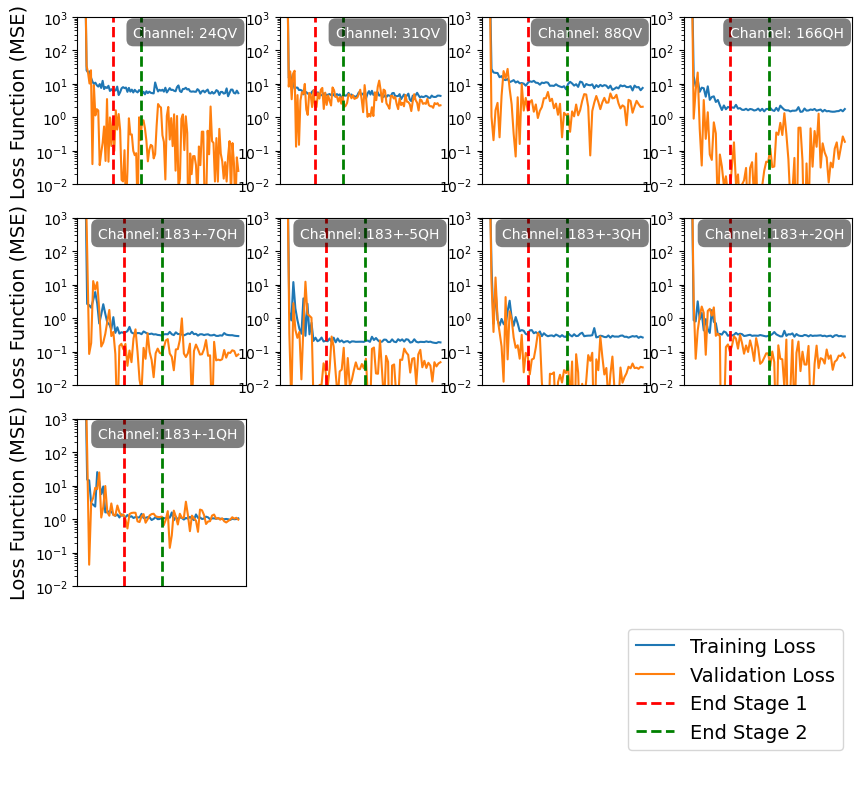

In [13]:
'''
Plot training diagnostics:
'''

loss_files = glob.glob('diagnostics/loss_data*.nc')

loss_data = {}

for ichan,channel in enumerate(sensor_info.feature_descriptions):

    loss_file = glob.glob(f'diagnostics/loss_data_{channel}_ocean.nc')[0]
    
    with xr.open_dataset(loss_file) as f:
        nstages = 3
        
        nbatches, nepochs1 = f.LossStage1.shape
        nbatches, nepochs2 = f.LossStage2.shape
        nbatches, nepochs3 = f.LossStage3.shape

        ntotepochs = nepochs1 + nepochs2 + nepochs3

        loss = np.zeros([ntotepochs*nbatches],dtype='f')
        valloss = np.zeros([ntotepochs*nbatches],dtype='f')

        beg1 = 0
        end1 = nbatches*nepochs1
        beg2 = end1
        end2 = end1 + nbatches*nepochs2
        beg3 = end2
        end3 = end2 + nbatches*nepochs3

        loss[beg1:end1] = f.LossStage1.T.values.reshape(-1)
        loss[beg2:end2] = f.LossStage2.T.values.reshape(-1)
        loss[beg3:end3] = f.LossStage3.T.values.reshape(-1)
        valloss[beg1:end1] = f.ValidationLossStage1.T.values.reshape(-1)
        valloss[beg2:end2] = f.ValidationLossStage2.T.values.reshape(-1)
        valloss[beg3:end3] = f.ValidationLossStage3.T.values.reshape(-1)

    loss_data[f'training_loss_{channel}'] = loss
    loss_data[f'validation_loss_{channel}'] = valloss


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow, icol].axis('off')  # hide unused panels
            continue
        channel = channels2plot[i]
        line1 = ax[irow,icol].plot(loss_data[f'training_loss_{channel}'][::2000], label='Training Loss')
        line2 = ax[irow,icol].plot(loss_data[f'validation_loss_{channel}'][::2000], label='Validation Loss')
        ax[irow,icol].set_yscale('log')
        ax[irow,icol].set_ylim(0.01,1000)
        ax[irow, icol].text(0.95, 0.95, f'Channel: {channel}', 
                            ha='right', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        line3 = ax[irow,icol].axvline(nbatches*nepochs1/2000, color='r', linestyle='--', linewidth=2, label='End Stage 1')
        line4 = ax[irow,icol].axvline(nbatches*(nepochs2+nepochs1)/2000, color='g', linestyle='--', linewidth=2, label='End Stage 2')


        if i == 0:
            # Capture legend handles from the first plot
            legend_handles, legend_labels = ax[irow, icol].get_legend_handles_labels()

        if icol == 0:
            ax[irow,icol].set_ylabel('Loss Function (MSE)', fontsize=14)
        if irow == nrows-1:
            ax[irow,icol].set_xlabel('Training', fontsize=14)


        ax[irow,icol].set_xticks([])
        i += 1


ax[nrows-1, ncols-1].legend(legend_handles, legend_labels, loc='upper right', fontsize=14)
plt.show()

In [31]:
'''
Load in test data and predict Tbs: Nonocean
'''

pixel_nums = np.arange(0,48)

with xr.open_dataset(f'training_data/{satellite}_training_data.nc') as f:
        
    sfctype = f.sfctype.values

    correct_sfc = sfctype > 1

    Tbs_all = f.Tbs.values[correct_sfc]
    scanpos = f.scanpos.values[correct_sfc]
    sfctype_all = sfctype[correct_sfc]

y_true = {}
y_pred = {}

In [32]:
for ipix in tqdm(pixel_nums):

    correct_scanpos = scanpos == ipix
    scan_position = scanpos[correct_scanpos]
    Tbs = Tbs_all[correct_scanpos]
    sfctype = sfctype_all[correct_scanpos]

    #---Split data into train/test/val:
    train_indcs, test_indcs, val_indcs = local_functions.split_data_indcs(Tbs)

    Tbs_test = Tbs[test_indcs]
    sfctype  = sfctype[test_indcs]
    scan_position = scan_position[test_indcs]

    y_true[f'scanpos{ipix}'] = Tbs_test

    #Run predictions on test data:
    y_pred[f'scanpos{ipix}'] = model_operations.run_predictions(Tbs_test, sfctype, scan_position, model_tree, keep_dims=False)
    raise

  0%|                                                                                                                                  | 0/48 [00:01<?, ?it/s]


RuntimeError: No active exception to reraise

In [33]:
'''
Calculate error statistics
'''


rmse = {}
mse = {}
mae = {}
error = {}
mean_error = {}
std_error = {}

for ipix in pixel_nums:

    rmse[f'scanpos{ipix}'] = stats.root_mean_squared_error(y_pred[f'scanpos{ipix}'], y_true[f'scanpos{ipix}'], axis=0)
    mse[f'scanpos{ipix}'] = stats.mean_squared_error(y_pred[f'scanpos{ipix}'], y_true[f'scanpos{ipix}'], axis=0)
    mae[f'scanpos{ipix}'] = stats.mean_absolute_error(y_pred[f'scanpos{ipix}'], y_true[f'scanpos{ipix}'], axis=0)

    error[f'scanpos{ipix}'] = y_pred[f'scanpos{ipix}'] - y_true[f'scanpos{ipix}']
    mean_error[f'scanpos{ipix}'] = np.mean(error[f'scanpos{ipix}'], axis=0)
    std_error[f'scanpos{ipix}']  = np.std(error[f'scanpos{ipix}'], axis=0)

# print('Error stats:')
# print('mean: ', mean_error)
# print('std: ', std_error)

    # mean_error[f'scanpos{ipix}'].astype(np.float32).tofile(f'eval_stats/mean_non_scanpos{ipix}.arr', 
    #                                                        sep='', format='unformatted')
    # std_error[f'scanpos{ipix}'].astype(np.float32).tofile(f'eval_stats/std_non_scanpos{ipix}.arr', 
    #                                                       sep='', format='unformatted')
    raise

RuntimeError: No active exception to reraise

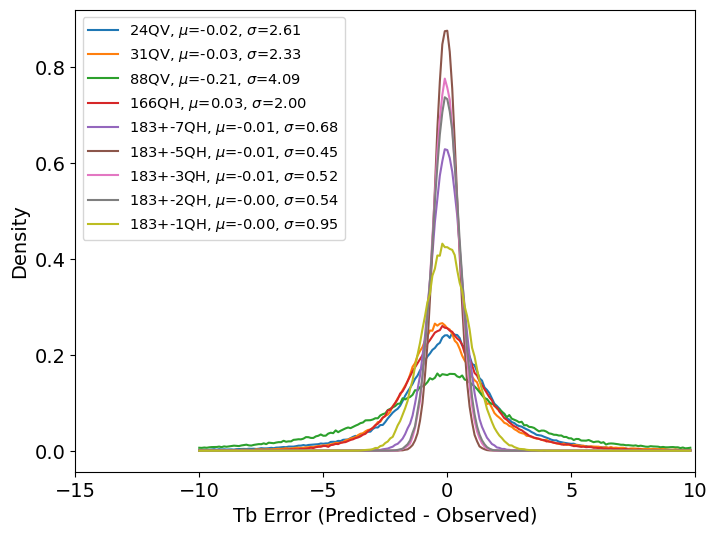

In [34]:

scan_position = 0

nchans = sensor_info.nchannels

bin_edges = np.arange(-10,10,0.1)
dens = np.zeros([bin_edges.size - 1,nchans])

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    dens[:,ichan], bin_edges = np.histogram(error[f'scanpos{scan_position}'][:,ichan], bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], dens[:,ichan], 
        label=f'{channel}, $\\mu$={mean_error[f'scanpos{scan_position}'][ichan]:.2f}, $\\sigma$={std_error[f'scanpos{scan_position}'][ichan]:.2f}')

plt.xlim(-15,10)
plt.tick_params('both', labelsize=14)
plt.xlabel('Tb Error (Predicted - Observed)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper left', fontsize=10.5)


plt.show()


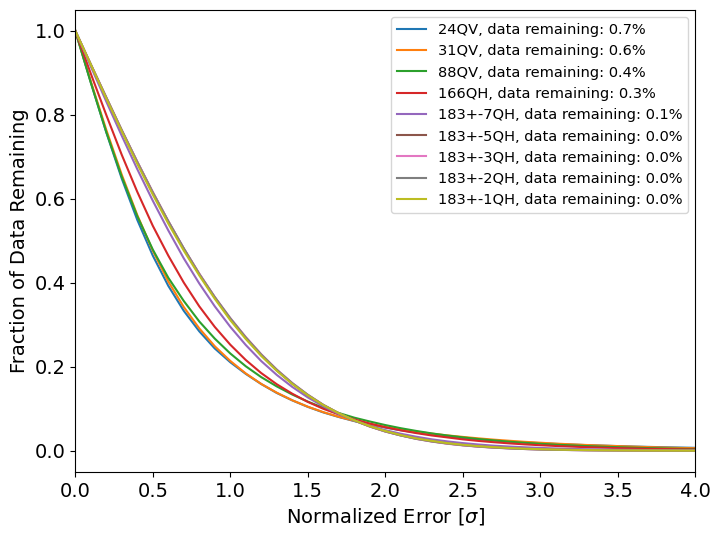

In [26]:
'''
Plot fraction of data that remains as a function of 
standard deviation (sigma) from the mean.
'''

bin_edges = np.arange(0,10,0.1)
#Get errors in units of sigma
norm_error = ((error[f'scanpos{scan_position}'] - error[f'scanpos{scan_position}'].mean(axis=0))/
              error[f'scanpos{scan_position}'].std(axis=0))

frac_rem = np.zeros([bin_edges.size - 1, nchans])
for ichan, channel in enumerate(sensor_info.feature_descriptions):
    #Get histogram of absolute error [sigma] as a function of sigma
    counts, bin_edges = np.histogram(np.abs(norm_error[:,ichan]), bins=bin_edges)

    #Get reverse cumulative sum of counts as a function of sigma:
    revcumsum = np.flip(np.cumsum(np.flip(counts)))

    #Calculate the fraction of remaining data as a function of sigma:
    frac = revcumsum / counts.sum()

    #Save this result. It is the fraction of data remaining as we move
    #   farther from the mean in sigma space.
    frac_rem[:,ichan] = frac

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    plt.plot(bin_edges[:-1], frac_rem[:,ichan], 
             label=f'{channel}, data remaining: {frac_rem[40,ichan]*100.:.1f}%')

plt.xlim(0,4)
plt.tick_params('both', labelsize=14)
plt.xlabel('Normalized Error [$\\sigma$]', fontsize=14)
plt.ylabel('Fraction of Data Remaining', fontsize=14)
plt.legend(fontsize=10.5)
plt.show()


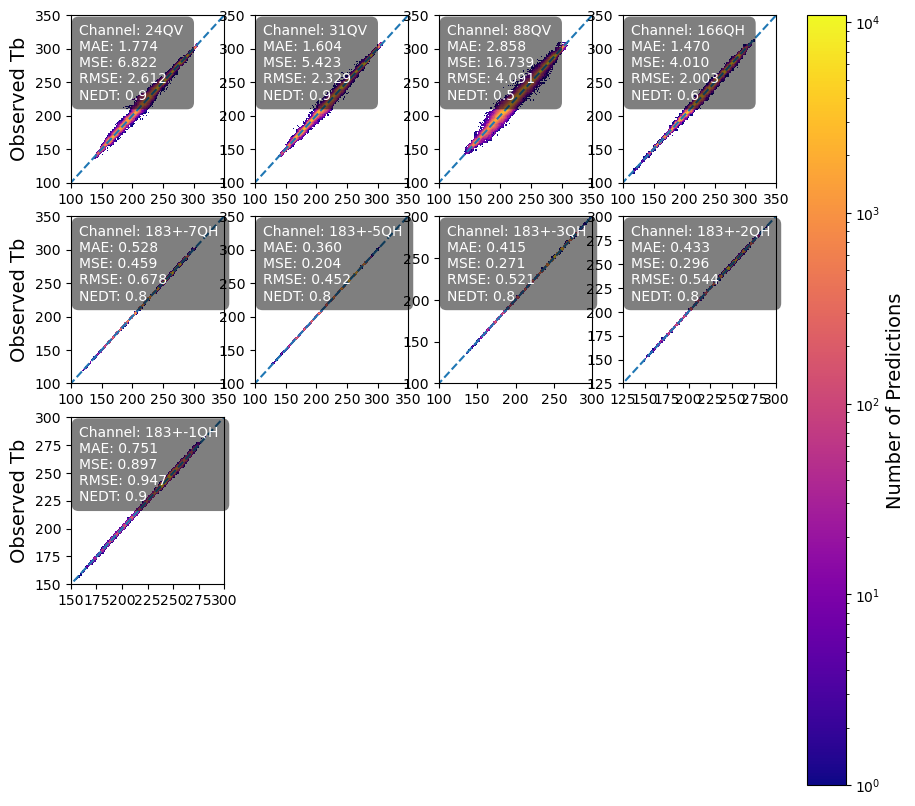

In [27]:
'''
Plot results
'''

nedt = sensor_info.nedt

nrows, ncols = (4,4)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0

channels2plot = sensor_info.feature_descriptions
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow,icol].axis('off')
            continue
        channel = channels2plot[i]
        min_lim, max_lim = y_true[f'scanpos{scan_position}'][:,i].min(), y_true[f'scanpos{scan_position}'][:,i].max()
        mesh = ax[irow,icol].hist2d(y_pred[f'scanpos{scan_position}'][:,i],y_true[f'scanpos{scan_position}'][:,i],
                                    bins=100, norm=LogNorm(), cmap='plasma',
                             range=[[min_lim,max_lim],[min_lim,max_lim]])
        ticks = ax[irow,icol].get_yticks()
        ax[irow,icol].set_xticks(ticks); ax[irow,icol].set_yticks(ticks)
        ax[irow,icol].plot(np.arange(0,400), np.arange(0,400), linestyle='--')
        ax[irow, icol].text(0.05, 0.95, 
        f'Channel: {channel} \nMAE: {mae[f'scanpos{scan_position}'][i]:.3f} \nMSE: {mse[f'scanpos{scan_position}'][i]:.3f} \nRMSE: {rmse[f'scanpos{scan_position}'][i]:.3f} \nNEDT: {nedt[i]}', 
                            ha='left', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        if icol == 0:
            ax[irow,icol].set_ylabel('Observed Tb', fontsize=14)

        if irow == nrows - 1:
            ax[irow,icol].set_xlabel('Predicted Tb', fontsize=14)
        i += 1

#ax[-1,-1].set_yticks([]), ax[-1,-1].set_xticks([])
cbar = fig.colorbar(mesh[3], ax=ax, orientation='vertical', fraction=0.05, pad=0.04 )
cbar.set_label('Number of Predictions', fontsize=14)
plt.show()

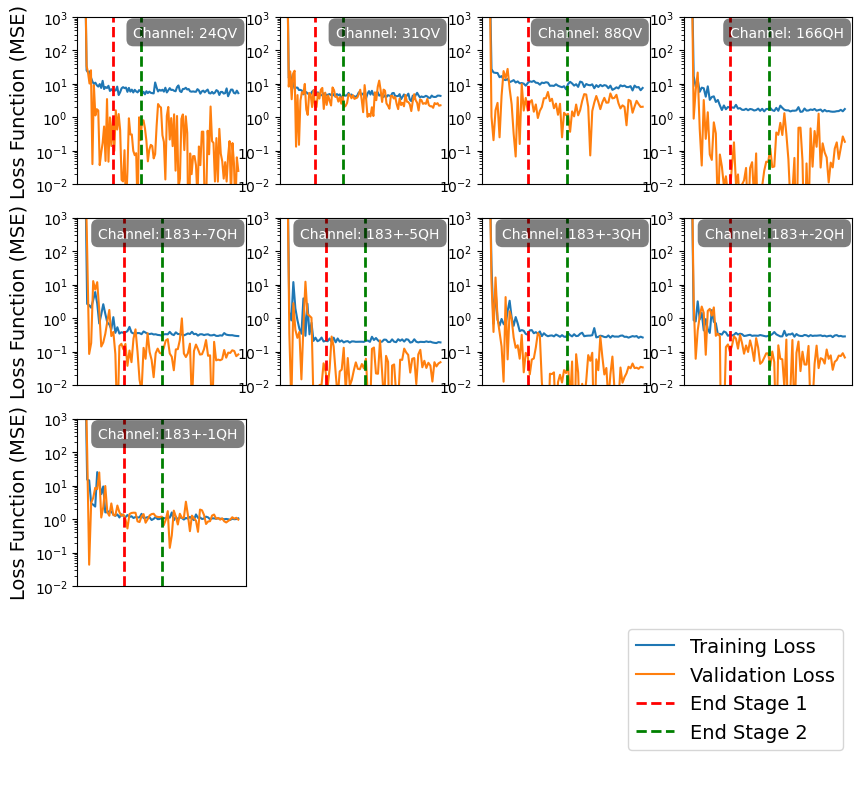

In [28]:
'''
Plot training diagnostics:
'''

loss_files = glob.glob('diagnostics/loss_data*.nc')

loss_data = {}

for ichan,channel in enumerate(sensor_info.feature_descriptions):

    loss_file = glob.glob(f'diagnostics/loss_data_{channel}_ocean.nc')[0]
    
    with xr.open_dataset(loss_file) as f:
        nstages = 3
        
        nbatches, nepochs1 = f.LossStage1.shape
        nbatches, nepochs2 = f.LossStage2.shape
        nbatches, nepochs3 = f.LossStage3.shape

        ntotepochs = nepochs1 + nepochs2 + nepochs3

        loss = np.zeros([ntotepochs*nbatches],dtype='f')
        valloss = np.zeros([ntotepochs*nbatches],dtype='f')

        beg1 = 0
        end1 = nbatches*nepochs1
        beg2 = end1
        end2 = end1 + nbatches*nepochs2
        beg3 = end2
        end3 = end2 + nbatches*nepochs3

        loss[beg1:end1] = f.LossStage1.T.values.reshape(-1)
        loss[beg2:end2] = f.LossStage2.T.values.reshape(-1)
        loss[beg3:end3] = f.LossStage3.T.values.reshape(-1)
        valloss[beg1:end1] = f.ValidationLossStage1.T.values.reshape(-1)
        valloss[beg2:end2] = f.ValidationLossStage2.T.values.reshape(-1)
        valloss[beg3:end3] = f.ValidationLossStage3.T.values.reshape(-1)

    loss_data[f'training_loss_{channel}'] = loss
    loss_data[f'validation_loss_{channel}'] = valloss


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow, icol].axis('off')  # hide unused panels
            continue
        channel = channels2plot[i]
        line1 = ax[irow,icol].plot(loss_data[f'training_loss_{channel}'][::2000], label='Training Loss')
        line2 = ax[irow,icol].plot(loss_data[f'validation_loss_{channel}'][::2000], label='Validation Loss')
        ax[irow,icol].set_yscale('log')
        ax[irow,icol].set_ylim(0.01,1000)
        ax[irow, icol].text(0.95, 0.95, f'Channel: {channel}', 
                            ha='right', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        line3 = ax[irow,icol].axvline(nbatches*nepochs1/2000, color='r', linestyle='--', linewidth=2, label='End Stage 1')
        line4 = ax[irow,icol].axvline(nbatches*(nepochs2+nepochs1)/2000, color='g', linestyle='--', linewidth=2, label='End Stage 2')


        if i == 0:
            # Capture legend handles from the first plot
            legend_handles, legend_labels = ax[irow, icol].get_legend_handles_labels()

        if icol == 0:
            ax[irow,icol].set_ylabel('Loss Function (MSE)', fontsize=14)
        if irow == nrows-1:
            ax[irow,icol].set_xlabel('Training', fontsize=14)


        ax[irow,icol].set_xticks([])
        i += 1


ax[nrows-1, ncols-1].legend(legend_handles, legend_labels, loc='upper right', fontsize=14)
plt.show()